# baseline v3

이 베이스라인 코드는 `사전학습 모델 로드`, `배치 학습`, `파인튜닝`, `양자화`, `PEFT` 등이 적용된 버전입니다.

Colab의 GPU 환경에서 개발되었습니다.
- 런타임 - 런타임 유형 변경 - GPU로 변경(T4 GPU 등)



# 1. 환경 준비

개발 환경에 필요한 라이브러리 버전을 고정하고 최신 버전으로 라이브러리를 업데이트합니다.

- 아래 셀 실행
- 실행 완료 후 런타임 - 세션 다시 시작

In [1]:
# !pip uninstall torch -y

In [1]:
!pip uninstall unsloth unsloth-zoo zetascale torch torchao transformers bitsandbytes accelerate peft -y

Found existing installation: torch 2.8.0
Uninstalling torch-2.8.0:
  Successfully uninstalled torch-2.8.0
Found existing installation: transformers 4.46.2
Uninstalling transformers-4.46.2:
  Successfully uninstalled transformers-4.46.2
Found existing installation: bitsandbytes 0.48.1
Uninstalling bitsandbytes-0.48.1:
  Successfully uninstalled bitsandbytes-0.48.1
Found existing installation: accelerate 1.11.0
Uninstalling accelerate-1.11.0:
  Successfully uninstalled accelerate-1.11.0
Found existing installation: peft 0.17.1
Uninstalling peft-0.17.1:
  Successfully uninstalled peft-0.17.1


In [1]:
# 그 다음 다시 설치
!pip install -U "Pillow<12.0,>=9.0" "git+https://github.com/huggingface/transformers" "accelerate>=0.34.2" \
  "peft>=0.13.2" "bitsandbytes>=0.43.1" datasets pandas torch==2.8.0 torchvision

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-bd5x1jnv
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-bd5x1jnv
  Resolved https://github.com/huggingface/transformers to commit 77e8b9f8dfc8e736ad2f603a5b2ae2b1076ed271
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached torch-2.8.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.24.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached nvidia_nccl_cu12-2.27.3-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
  Using cached triton-3.4.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.7 kB)
INFO: pip is looking at multiple versions of torchvision to determine which ve

In [3]:
# PyTorch (CUDA 12.1)
# !pip install --upgrade --index-url https://download.pytorch.org/whl/cu121 \
#   torch torchvision torchaudio

In [4]:
# 모델/로더 필수
# !pip install --upgrade unsloth bitsandbytes transformers accelerate datasets pandas Pillow

In [5]:
# # 1. pip 자체를 최신 버전으로 업그레이드
# !pip install -U pip

# # 2. (핵심) Unsloth 라이브러리 설치
# # 노트북에서는 CUDA 12.1과 PyTorch 2.4.0 환경에 최적화된 버전을 설치합니다.
# !pip install -U "unsloth[cu121-torch240] @ git+https://github.com/unslothai/unsloth.git"

# # 3. 나머지 의존성 패키지 설치
# !pip install -U "transformers>=4.57.0" "peft" "bitsandbytes" "accelerate" \
#   "datasets" "pandas" "Pillow<12.0,>=9.0"

In [6]:
# (핵심) unsloth를 git main 브랜치에서 설치합니다.
# !pip install -U "unsloth[cu121-torch240] @ git+https://github.com/unslothai/unsloth.git"

In [7]:
# # 나머지 패키지를 최신 버전으로 설치합니다.
# !pip install -U "transformers>=4.57.0" "peft" "bitsandbytes" "accelerate" \
#   "datasets" "pandas" "Pillow<12.0,>=9.0"

In [8]:
# !pip -q install "Pillow<12.0,>=9.0" "transformers>=4.44.2" "accelerate>=0.34.2" "peft>=0.13.2" "bitsandbytes>=0.43.1" datasets pandas torch torchvision --upgrade

# 2. 데이터 준비

개발에 필요한 데이터를 준비합니다.

- train.csv, train 폴더
- test.csv, test 폴더
- sample_submission.csv

본 베이스라인은 colab에서 구글 드라이브를 마운트하여 사용합니다.

데이터를 압축 해제하는데 몇 분 정도의 시간이 소요됩니다.

#### 실습 참고 내용

    챕터 2-2 합성 데이터 실습
    - 구글 드라이브 마운트 : drive()

In [9]:
# # 구글드라이브 마운트
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# 압축 해제
# !unzip "/content/drive/My Drive/SSAFY/A123/2025-ssafy-14" -d "/content/"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/test/test_2776.jpg  
  inflating: /content/test/test_2777.jpg  
  inflating: /content/test/test_2778.jpg  
  inflating: /content/test/test_2779.jpg  
  inflating: /content/test/test_2780.jpg  
  inflating: /content/test/test_2781.jpg  
  inflating: /content/test/test_2782.jpg  
  inflating: /content/test/test_2783.jpg  
  inflating: /content/test/test_2784.jpg  
  inflating: /content/test/test_2785.jpg  
  inflating: /content/test/test_2786.jpg  
  inflating: /content/test/test_2787.jpg  
  inflating: /content/test/test_2788.jpg  
  inflating: /content/test/test_2789.jpg  
  inflating: /content/test/test_2790.jpg  
  inflating: /content/test/test_2791.jpg  
  inflating: /content/test/test_2792.jpg  
  inflating: /content/test/test_2793.jpg  
  inflating: /content/test/test_2794.jpg  
  inflating: /content/test/test_2795.jpg  
  inflating: /content/test/test_2796.jpg  
  inflating: /content/test/test_2797.jpg  
  inflating: /cont

# 3. 라이브러리, 데이터, 설정

In [2]:
# 모델/로더 필수 셀(#VSC-2ac973d1)에 추가

!pip install --upgrade albumentations

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os, io, math, random, textwrap, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
import torch
from typing import Dict, List, Any
from transformers import (
    AutoModelForVision2Seq,
    AutoProcessor,
    BitsAndBytesConfig,
    get_linear_schedule_with_warmup,
    Qwen3VLForConditionalGeneration # Import the new model class
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from tqdm import tqdm

# 이미지 로드 시 픽셀 제한 해제
Image.MAX_IMAGE_PIXELS = None

# 디바이스 GPU 우선 사용 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 사전 학습 모델 정의
# ⭐ 모델 숫자 맞는지 확인 (4에서 32로 바뀜)
MODEL_ID = "Qwen/Qwen3-VL-32B-Instruct" # Update MODEL_ID
IMAGE_SIZE = 384
MAX_NEW_TOKENS = 8
SEED = 42
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# 데이터셋 로드
# ⭐ 경로 수정 필요 (현재 경로는 코랩 기준임)
train_df = pd.read_csv("/home/team067/train.csv")
test_df  = pd.read_csv("/home/team067/test.csv")


# 학습데이터 200개만 추출 -> 이아니라 전부할거임
# train_df = train_df.sample(n=200, random_state=SEED).reset_index(drop=True)

/home/team067/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


---

# 4. 데이터 시각화
맞아, 지금 단계에서 데이터 시각화는 꼭 해둘 만해요.
라벨 분포, 이미지 상태(사이즈/깨짐), 샘플 미리보기(질문·선지 포함)를 빨리 확인하면 이후 학습 이슈를 크게 줄일 수 있어요.

- 제공되는 데이터 분포 확인하기

---

## 4-1. 컬럼/경로 점검 + 라벨 분포(막대/파이) + 불균형 지표

In [13]:
"""
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# ==== 설정 ====
IMG_COL_CANDIDATES = ["path", "image_path", "img_path", "image"]
LABEL_COL = "answer"      # 라벨이 다른 이름이면 바꿔주세요
Q_COL = "question"
OPT_COLS = ["a", "b", "c", "d"]
IMAGE_ROOT = "/"          # 절대경로면 "/" 유지, 상대경로면 베이스 경로 지정

def pick_image_col(df):
    for c in IMG_COL_CANDIDATES:
        if c in df.columns:
            return c
    raise KeyError(f"이미지 경로 컬럼을 찾지 못했습니다. 후보: {IMG_COL_CANDIDATES}")

IMG_COL = pick_image_col(train_df)

def exists_count(df):
    cnt = 0
    for p in df[IMG_COL].astype(str):
        abspath = p if os.path.isabs(p) else os.path.join(IMAGE_ROOT, p)
        if os.path.exists(abspath):
            cnt += 1
    return cnt

def show_label_distribution(train_df, test_df=None, label_col=LABEL_COL):
    vc = train_df[label_col].value_counts().sort_index()
    ratio = vc.max() / vc.min() if len(vc)>1 else 1.0

    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1])

    # 막대
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.bar(vc.index.astype(str), vc.values)
    ax1.set_title("Answer Distribution (Train)")
    ax1.set_xlabel("Class")
    ax1.set_ylabel("Count")

    # 파이
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.pie(vc.values, labels=vc.index.astype(str), autopct="%1.1f%%")
    ax2.set_title("Answer Proportions (Train)")

    # 텍스트 박스
    ax3 = fig.add_subplot(gs[1, :])
    info = [
        "Dataset Stats",
        "--------------",
        f"Train samples: {len(train_df)}",
        f"Test  samples: {len(test_df) if test_df is not None else 'N/A'}",
        "",
        f"Label counts:\n{vc.to_string()}",
        "",
        f"Imbalance ratio (max/min): {ratio:.2f}",
        "",
        f"Image column: {IMG_COL}",
        f"Train images existing: {exists_count(train_df)} / {len(train_df)}",
        f"Test  images existing:  {exists_count(test_df) if test_df is not None else 'N/A'}",
    ]
    ax3.text(0.01, 0.05, "\n".join(info), family="monospace", fontsize=12)
    ax3.axis("off")
    plt.tight_layout()
    plt.show()

show_label_distribution(train_df, test_df)
"""


'\nimport os\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom PIL import Image, ImageDraw, ImageFont\n\n# ==== 설정 ====\nIMG_COL_CANDIDATES = ["path", "image_path", "img_path", "image"]\nLABEL_COL = "answer"      # 라벨이 다른 이름이면 바꿔주세요\nQ_COL = "question"\nOPT_COLS = ["a", "b", "c", "d"]\nIMAGE_ROOT = "/"          # 절대경로면 "/" 유지, 상대경로면 베이스 경로 지정\n\ndef pick_image_col(df):\n    for c in IMG_COL_CANDIDATES:\n        if c in df.columns:\n            return c\n    raise KeyError(f"이미지 경로 컬럼을 찾지 못했습니다. 후보: {IMG_COL_CANDIDATES}")\n\nIMG_COL = pick_image_col(train_df)\n\ndef exists_count(df):\n    cnt = 0\n    for p in df[IMG_COL].astype(str):\n        abspath = p if os.path.isabs(p) else os.path.join(IMAGE_ROOT, p)\n        if os.path.exists(abspath):\n            cnt += 1\n    return cnt\n\ndef show_label_distribution(train_df, test_df=None, label_col=LABEL_COL):\n    vc = train_df[label_col].value_counts().sort_index()\n    ratio = vc.max() / vc.min() if len(vc)>1 else 1.0\n\n    fig

## 4-2. 분할 전/후 분포 비교
“원래부터 균형인지”를 train/valid로 나눠도 유지되는지 함께 체크.

In [14]:
"""
def compare_distributions(all_df, train_df_split, valid_df_split, label_col=LABEL_COL):
    for name, df in {"ALL": all_df, "TRAIN": train_df_split, "VALID": valid_df_split}.items():
        vc = df[label_col].value_counts().sort_index()
        ratio = vc.max()/vc.min() if len(vc)>1 else 1.0
        print(f"\n[{name}]")
        print(vc)
        print(f"Imbalance ratio: {ratio:.2f}")

# 예: 9:1 단순 분할 (여기서는 stratify 없이 샘플)
split_idx = int(len(train_df)*0.9)
train_subset = train_df.iloc[:split_idx]
valid_subset = train_df.iloc[split_idx:]
compare_distributions(train_df, train_subset, valid_subset)
"""


'\ndef compare_distributions(all_df, train_df_split, valid_df_split, label_col=LABEL_COL):\n    for name, df in {"ALL": all_df, "TRAIN": train_df_split, "VALID": valid_df_split}.items():\n        vc = df[label_col].value_counts().sort_index()\n        ratio = vc.max()/vc.min() if len(vc)>1 else 1.0\n        print(f"\n[{name}]")\n        print(vc)\n        print(f"Imbalance ratio: {ratio:.2f}")\n\n# 예: 9:1 단순 분할 (여기서는 stratify 없이 샘플)\nsplit_idx = int(len(train_df)*0.9)\ntrain_subset = train_df.iloc[:split_idx]\nvalid_subset = train_df.iloc[split_idx:]\ncompare_distributions(train_df, train_subset, valid_subset)\n'

## 4-3. 이미지 메타(가로×세로) 분포 확인
“이미지 메타(가로×세로) 분포 확인”은 단순히 이미지 크기를 보기 위한 게 아니라, **모델 학습 과정에서 발생할 수 있는 오류·비효율을 미리 예방하기 위한 데이터 진단 단계**예요.

### 왜 이걸 하는가
#### 1️⃣ 이미지 크기 다양성을 파악해서 **전처리 정책**을 정하기 위함
* Vision-Language 모델(`Qwen3-VL` 같은)은 입력 이미지 크기에 민감해요.
* 만약 데이터에 **극단적으로 큰 이미지(예: 4000×3000)**, **세로로 긴 이미지(예: 400×3000)**가 섞여 있다면:

  * GPU 메모리 초과(OOM) 발생
  * 학습 속도 저하
  * aspect ratio 왜곡 (물체가 눌리거나 길게 보임)
* 그래서 “전체 이미지의 크기 분포(가로·세로)”를 보고,

  * 대부분이 300~600px이라면 그대로 리사이즈 가능
  * 일부만 크면, outlier만 필터링
  * 세로로 긴 이미지가 많으면, **padding 전략**(예: letterbox)을 고려

#### 2️⃣ 데이터 품질 문제를 미리 탐지
* 크기가 `0x0`, `1x1`, 혹은 열 수 없는 손상된 파일이 있으면
  → `Image.open()` 단계에서 오류가 납니다.
* 이런 이미지를 학습 중에 처음 만나면 **훈련이 중단**될 수 있으므로,
  사전 점검으로 `None` 값이 있는 파일 경로를 미리 찾습니다.

#### 3️⃣ 모델의 **입력 해상도(IMAGE_SIZE)**를 결정할 때 참고

* 지금 `IMAGE_SIZE = 384`로 지정되어 있는데,
  분포를 보면 평균적인 이미지 폭/높이를 확인할 수 있죠.
* 예를 들어 대부분이 1280×720이면 `512` 정도로 올려도 좋고,
  대부분이 300~400대면 `384` 그대로 두는 게 효율적이에요.

#### 4️⃣ **리사이즈/크롭 후 시각적 왜곡 위험** 확인

* 예를 들어 신발 사진인데 세로로 길쭉한 이미지가 많다면,
  `RandomResizedCrop(384,384)`를 쓰면 일부 영역이 잘릴 수 있어요.
* 분포를 보고 “aspect ratio가 안정적인가”를 확인함으로써
  증강 강도를 안전하게 조절할 수 있습니다.


#### 📊 예시 해석

| 항목               | 의미         | 예시 해석                 |
| ---------------- | ---------- | --------------------- |
| Width histogram  | 가로 길이 분포   | 대부분 300~500이면 문제 없음   |
| Height histogram | 세로 길이 분포   | 일부만 1000 이상이면 리사이즈 고려 |
| 비정상값(None)       | 열 수 없는 이미지 | 경로 문제 or 손상된 파일       |


#### ✅ 요약

> 이미지 크기 분포를 보는 이유는 **데이터의 일관성과 품질을 점검하고**,
> **모델 입력 크기 및 증강 전략을 안전하게 결정하기 위해서**예요.




In [15]:
"""
# ===== Robust image meta checker (drop-in) =====
import os, io, math, random, textwrap, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 0) 어떤 컬럼이 경로인지 자동 탐색
def detect_image_col(df, candidates=("path","image_path","img_path","image","img","filepath","file")):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"이미지 경로 컬럼을 찾지 못했습니다. 후보: {candidates}")

# 1) 경로를 실제 파일로 해석 (ROOT 후보 자동 탐색)
def detect_image_root(df, img_col, candidate_roots=None, sample_n=50):
    paths = df[img_col].astype(str).head(sample_n).tolist()
    paths = [p.strip().replace("\\","/") for p in paths]
    if candidate_roots is None:
        candidate_roots = [
            "",                      # 이미 절대경로일 수도 있음
            "/",
            "/home/team067",
            "/content",
            "/content/drive/My Drive",
        ]
    hit_counts = {}
    for root in candidate_roots:
        cnt = 0
        for p in paths:
            abspath = p if os.path.isabs(p) else os.path.join(root, p)
            if os.path.exists(abspath):
                cnt += 1
        hit_counts[root] = cnt
    # 가장 많이 맞는 ROOT 선택
    best_root = max(hit_counts, key=hit_counts.get)
    return best_root, hit_counts

# 2) 한 장의 크기 읽기 (파일만; URL/GS는 제외)
def read_size(abspath):
    try:
        with Image.open(abspath) as im:
            return im.size  # (W,H)
    except Exception:
        return None

# 3) 분포/요약 출력
def analyze_image_sizes(df, img_col=None, image_root=None, sample_n=1000):
    if img_col is None:
        img_col = detect_image_col(df)
    # ROOT 자동 검출
    if image_root is None:
        image_root, hits = detect_image_root(df, img_col)
        print("[ROOT 후보별 적중 개수]", hits)
        print("[선택된 IMAGE_ROOT]", image_root)

    # 사이즈 수집
    sub = df.sample(min(len(df), sample_n), random_state=42)
    ok, fail = [], []
    for p in sub[img_col].astype(str):
        p = p.strip().replace("\\","/")
        abspath = p if os.path.isabs(p) else os.path.join(image_root, p)
        if os.path.exists(abspath):
            s = read_size(abspath)
            (ok if s else fail).append((p, abspath))
            if s: ok[-1] = (*ok[-1], s)  # (rel, abs, (W,H))
        else:
            fail.append((p, abspath, None))

    if not ok:
        print("❌ 이미지 메타를 하나도 읽지 못했습니다.")
        print("  - CSV 경로 값이 실제 파일과 맞는지 확인하세요.")
        print("  - 예시 10개:")
        for i, t in enumerate(fail[:10]):
            print(f"  [{i}] CSV='{t[0]}'  -> resolved='{t[1]}'  (존재X)")
        return

    widths  = [w for *_ , (w,h) in ok]
    heights = [h for *_ , (w,h) in ok]
    aspect  = [w/h for w,h in zip(widths, heights) if h>0]

    # 요약 통계
    def stat(x):
        return dict(n=len(x), min=int(np.min(x)), p25=int(np.percentile(x,25)),
                    median=int(np.median(x)), p75=int(np.percentile(x,75)),
                    max=int(np.max(x)), mean=float(np.mean(x)))
    ws, hs = stat(widths), stat(heights)

    print(f"✅ 읽은 이미지: {len(ok)} / {len(sub)} (실패 {len(fail)})")
    print("Width  stat:", ws)
    print("Height stat:", hs)
    if aspect:
        asp = dict(n=len(aspect), min=round(min(aspect),3), p25=round(np.percentile(aspect,25),3),
                   median=round(np.median(aspect),3), p75=round(np.percentile(aspect,75),3),
                   max=round(max(aspect),3), mean=round(float(np.mean(aspect)),3))
        print("Aspect stat (W/H):", asp)

    # 실패 예시 몇 개
    if fail:
        print("\n⚠️ 열기 실패 예시 5개:")
        for i, t in enumerate(fail[:5]):
            rel, abs_p = t[0], t[1]
            print(f"  [{i}] CSV='{rel}' -> resolved='{abs_p}'")

    # 히스토그램
    plt.figure(figsize=(15,4.5))
    plt.subplot(1,3,1); plt.hist(widths, bins=30);  plt.title("Width");  plt.xlabel("px")
    plt.subplot(1,3,2); plt.hist(heights, bins=30); plt.title("Height"); plt.xlabel("px")
    plt.subplot(1,3,3); plt.hist(aspect, bins=30);  plt.title("Aspect ratio (W/H)")
    plt.tight_layout(); plt.show()

    # 리사이즈 권장안 (간단 규칙)
    rec = 384
    if np.median(widths) > 900 or np.median(heights) > 900: rec = 512
    if np.percentile(widths,90) > 1600 or np.percentile(heights,90) > 1600: rec = 448
    print(f"🔧 권장 입력 해상도 대략: {rec}px (현재 IMAGE_SIZE={globals().get('IMAGE_SIZE','?')})")

# ===== 실행 (train_df 로드 직후에) =====
analyze_image_sizes(train_df)
"""

'\n# ===== Robust image meta checker (drop-in) =====\nimport os, io, math, random, textwrap, sys\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom PIL import Image\n\n# 0) 어떤 컬럼이 경로인지 자동 탐색\ndef detect_image_col(df, candidates=("path","image_path","img_path","image","img","filepath","file")):\n    for c in candidates:\n        if c in df.columns:\n            return c\n    raise KeyError(f"이미지 경로 컬럼을 찾지 못했습니다. 후보: {candidates}")\n\n# 1) 경로를 실제 파일로 해석 (ROOT 후보 자동 탐색)\ndef detect_image_root(df, img_col, candidate_roots=None, sample_n=50):\n    paths = df[img_col].astype(str).head(sample_n).tolist()\n    paths = [p.strip().replace("\\","/") for p in paths]\n    if candidate_roots is None:\n        candidate_roots = [\n            "",                      # 이미 절대경로일 수도 있음\n            "/",\n            "/home/team067",\n            "/content",\n            "/content/drive/My Drive",\n        ]\n    hit_counts = {}\n    for root in candidate_roots:\n        cnt

# 5. 학습용 이미지 증강 파이프라인


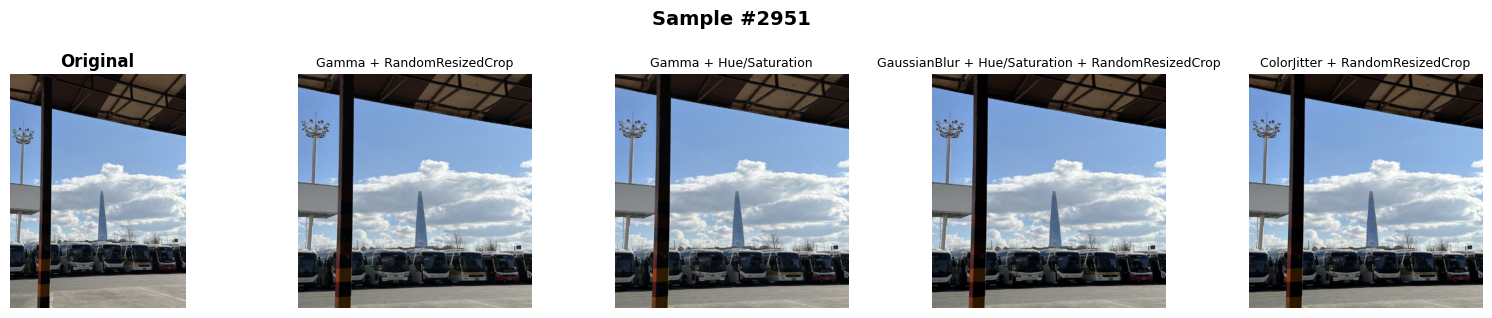

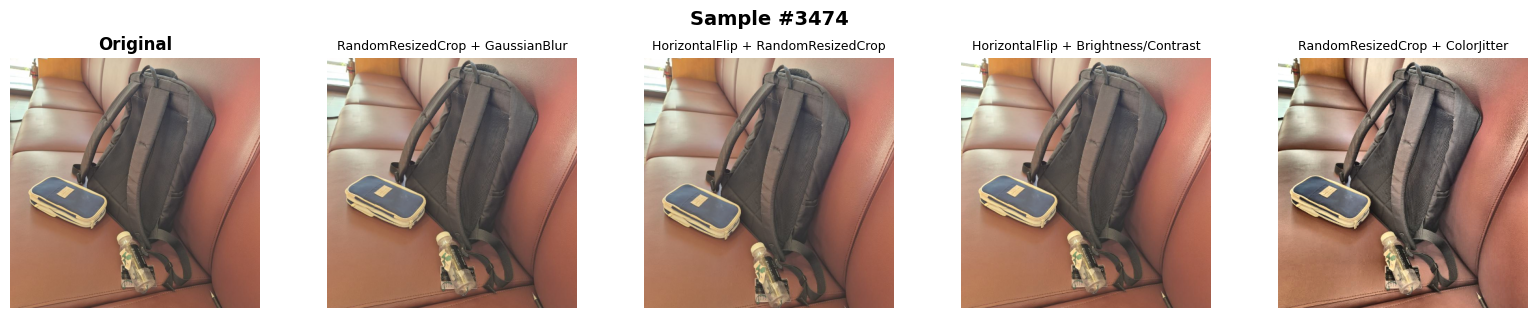

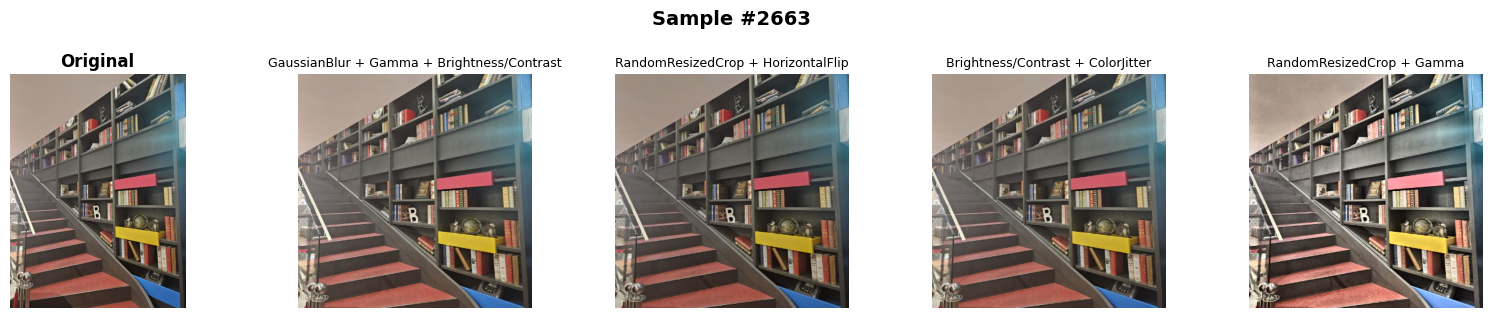

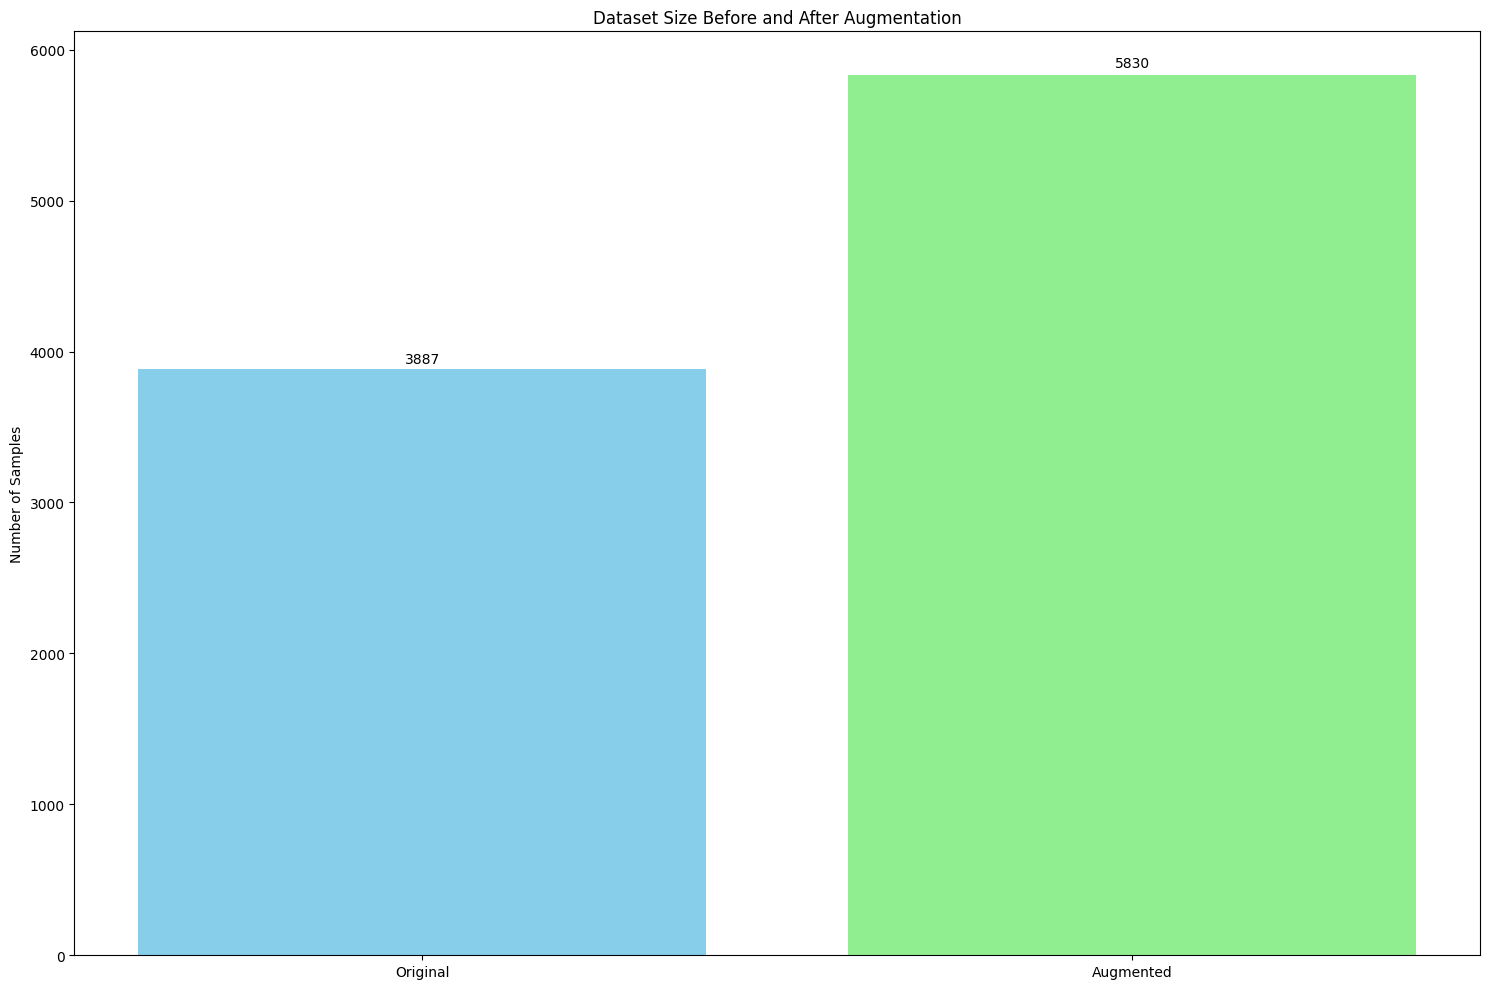

In [7]:
# ==========================
# 📸 데이터 증강 및 시각화 코드
# ==========================

import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---- 1️⃣ Albumentations 증강 파이프라인 정의 ----
# VQA에 최적화된 증강 파이프라인
AUGMENT = A.Compose([
    A.RandomResizedCrop(
        size=(384, 384),
        scale=(0.9, 1.0),     # 0.85 -> 0.9 (더 적은 크롭)
        ratio=(0.85, 1.15),   # 종횡비 범위 축소
        p=1.0
    ),
    A.ColorJitter(
        brightness=0.08,      # 0.1 -> 0.08 (더 약한 변화)
        contrast=0.08,        # 0.1 -> 0.08
        saturation=0.0,
        hue=0.0,
        p=0.4                 # 0.3 -> 0.4 (더 자주 적용)
    ),
    A.CLAHE(
        clip_limit=2.5,       # 2.0 -> 2.5 (약간 더 강한 대비)
        tile_grid_size=(8, 8),
        p=0.3                 # 0.2 -> 0.3
    ),
])


# ---- 2️⃣ 시각화 함수 ----
def visualize_aug_examples(df, img_col="path", n_samples=3, aug_per_sample=4):
    """
    n_samples: 몇 개의 이미지를 랜덤 샘플링할지
    aug_per_sample: 각 이미지당 몇 개의 증강 결과를 보여줄지
    """
    idxs = np.random.choice(len(df), size=min(n_samples, len(df)), replace=False)

    # 대표 증강 이름 라벨
    aug_labels = [
        "RandomResizedCrop",
        "Brightness/Contrast",
        "ColorJitter",
        "HorizontalFlip",
        "GaussianBlur",
        "Hue/Saturation",
        "Gamma",
    ]

    for idx in idxs:
        path = str(df.iloc[idx][img_col])
        img = Image.open(path).convert("RGB")

        fig, axs = plt.subplots(1, aug_per_sample + 1, figsize=(3.2*(aug_per_sample+1), 3.2))
        axs[0].imshow(img)
        axs[0].set_title("Original", fontsize=12, fontweight="bold")
        axs[0].axis("off")

        for k in range(aug_per_sample):
            aug_img = AUGMENT(image=np.array(img))["image"]
            axs[k+1].imshow(aug_img)

            # 랜덤 조합 라벨 (2~3개 정도 섞어서 제목에 표시)
            selected_labels = np.random.choice(aug_labels, size=random.randint(2,3), replace=False)
            axs[k+1].set_title(" + ".join(selected_labels), fontsize=9)
            axs[k+1].axis("off")

        plt.suptitle(f"Sample #{idx}", fontsize=14, fontweight="bold")
        plt.tight_layout()
        plt.show()

# ---- 3️⃣ 증강 예시 시각화 실행 ----
visualize_aug_examples(train_df, img_col="path", n_samples=3, aug_per_sample=4)


# ---- 4️⃣ 데이터 분포 변화 확인 ----
def show_dataset_growth(original_df, augmented_factor=2):
    original_count = len(original_df)
    augmented_count = int(original_count * augmented_factor)

    plt.figure(figsize=(15, 10))
    plt.bar(["Original", "Augmented"], [original_count, augmented_count], color=["skyblue", "lightgreen"])
    plt.title("Dataset Size Before and After Augmentation")
    plt.ylabel("Number of Samples")
    plt.text(0, original_count*1.01, f"{original_count}", ha="center")
    plt.text(1, augmented_count*1.01, f"{augmented_count}", ha="center")
    plt.tight_layout()
    plt.show()

show_dataset_growth(train_df, augmented_factor=1.5)


# 6. 모델, Processor

7.5GB 정도의 모델 다운로드가 진행됩니다. 10~20분 정도가 소요됩니다.

#### 실습 참고 내용

    챕터 5-1 PEFT(파라미터 효율적 튜닝)
    - LoRA 구현 : LoraConfig()

### 기존코드

In [8]:
!nvidia-smi

Sun Oct 26 05:04:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             44W /  400W |       6MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [9]:
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor # Ensure Qwen3VLForConditionalGeneration is imported here

# 양자화
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, 
)

# 프로세서
processor = AutoProcessor.from_pretrained(
    MODEL_ID,
    trust_remote_code=True,
)

# 사전학습 모델
base_model = Qwen3VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    # 추가: 로드 방식 변경으로 충돌 회피 시도
    low_cpu_mem_usage=True, 
)

# 양자화 모델로 로드
base_model = prepare_model_for_kbit_training(base_model)
base_model.gradient_checkpointing_enable()

# LoRA 세팅
lora_config = LoraConfig(
    r=12,
    lora_alpha=24,
    lora_dropout=0.07,
    bias="none",
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    task_type="CAUSAL_LM",
)

# PEFT 모델 생성
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

Loading checkpoint shards: 100%|██████████| 14/14 [04:18<00:00, 18.49s/it]


trainable params: 100,663,296 || all params: 33,458,053,360 || trainable%: 0.3009


# 6. 프롬프트 템플릿

#### 실습 참고 내용

    챕터 5-1 PEFT(파라미터 효율적 튜닝)
    - 프롬프트 템플릿 : convert_to_chatml(), formatting_prompts_func()

In [16]:
# 모델 지시사항
SYSTEM_INSTRUCT = (
    # 1. 역할 부여 (가이드북 "역할 부여" 패턴 적용)
    # - 명확한 전문가 역할 정의로 답변의 전문성과 일관성 확보
    "You are an expert visual analysis AI specialized in multiple-choice questions.\n"
    "Your capabilities include:\n"
    "1. Precise image analysis\n"
    "2. Contextual understanding\n"
    "3. Logical reasoning\n\n"

    # 2. 명확한 출력 형식 (가이드북 "원하는 출력 형식 지시" 원칙 적용)
    # - 단일 문자만 출력하도록 강제하여 후처리 필요성 최소화
    "OUTPUT REQUIREMENTS:\n"
    "- Return exactly one lowercase letter (a, b, c, or d)\n"
    "- No other text, punctuation, or explanations\n"
    "- No spaces or line breaks\n\n"

    # 3. 품질 기준 (가이드북 "명확하고 구체적으로 묻기" 원칙 적용)
    # - 분석 품질 기준을 명시하여 더 신중한 답변 유도
    "QUALITY STANDARDS:\n"
    "1. Examine all visual details thoroughly\n"
    "2. Consider the specific context of each question\n"
    "3. Evaluate all options systematically\n"
    "4. Choose the single most accurate answer based on visual evidence"

    # 4. System Instruction에 부정문 관련 가이드 추가
    "SPECIAL INSTRUCTIONS:\n"
    "- For negative questions (e.g., 'NOT included', 'CANNOT see'), carefully check all options\n"
    "- Pay extra attention to excluded or missing elements\n"
)

# 프롬프트 템플릿
def build_mc_prompt(question, a, b, c, d):
    # 부정문 여부 확인
    is_negative = any(word in question.lower()
                     for word in ['않은', '없는', '제외', 'not', 'except', 'missing'])
    negative_alert = (
        "! NEGATIVE QUESTION ALERT !\n"
        "- Focus on what is NOT present in the image\n"
        "- Check all options carefully\n\n"
        if is_negative else ""
    )
    # 1. 단계적 접근 (가이드북 "단계적 접근" 패턴 적용)
    # - 분석 과정을 명확한 단계로 구분하여 더 체계적인 답변 유도
    return (
        "TASK: Visual Question Analysis\n\n"
        # 부정문일 경우 특별 지시사항 추가
        f"{negative_alert}"

        # 2. 맥락 제공 (가이드북 "필요한 맥락 제공" 원칙 적용)
        # - 질문과 선택지를 구조화하여 제시
        f"QUESTION TO ANALYZE:\n{question}\n\n"
        f"OPTIONS TO EVALUATE:\n"
        f"a) {a}\n"
        f"b) {b}\n"
        f"c) {c}\n"
        f"d) {d}\n\n"

        # 3. 분석 단계 명시 (가이드북 "Chain-of-Thought" 패턴 적용)
        # - 모델의 분석 과정을 단계별로 안내
        "ANALYSIS STEPS:\n"
        "1. Examine all visual elements in the image\n"
        "2. Understand the specific requirements of the question\n"
        "3. Consider each option against the visual evidence\n"
        "4. Select the most accurate answer\n\n"

        # 4. 최종 출력 형식 재강조
        # - 마지막에 한 번 더 출력 형식을 강조하여 정확한 응답 유도
        "RESPONSE FORMAT:\n"
        "Provide exactly one lowercase letter (a, b, c, or d) representing the most accurate answer."
    )

# 7. Custom Dataset, Collator

#### 실습 참고 내용

    챕터 1-2 MLP 구현
    - TensorDataset()

    챕터 5-2 데이터 생성 및 파인튜닝 (향후 학습 분량)
    - IntentDataset()

In [17]:
# 커스텀 데이터셋
class VQAMCDataset(Dataset):
    def __init__(self, df, processor, train=True, augment=None):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.train = train
        self.augment = augment  # Albumentations 객체 받기

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["path"]).convert("RGB")

        # 🧩 학습 시에만 증강 적용
        if self.train and self.augment is not None:
            img = np.array(img)
            img = self.augment(image=img)["image"]
            img = Image.fromarray(img)

        q = str(row["question"])
        a, b, c, d = str(row["a"]), str(row["b"]), str(row["c"]), str(row["d"])
        user_text = build_mc_prompt(q, a, b, c, d)

        messages = [
            {"role":"system","content":[{"type":"text","text":SYSTEM_INSTRUCT}]},
            {"role":"user","content":[
                {"type":"image","image":img},
                {"type":"text","text":user_text}
            ]},
        ]
        if self.train:
            gold = str(row["answer"]).strip().lower()
            # 안전장치: a/b/c/d 아닌 경우 기본값
            if gold not in ("a","b","c","d"):
                gold = "a"
            messages.append({"role":"assistant","content":[{"type":"text","text":gold}]})

        return {"messages": messages}  # "image"는 없어도 OK


# 데이터 콜레이터
@dataclass
class DataCollator:
    processor: Any
    train: bool = True

    def __call__(self, batch):
        input_texts, input_images = [], []
        noans_texts, noans_images = [], []
        has_gold = self.train

        for sample in batch:
            messages = sample["messages"]

            if has_gold:
                # 정답 포함(full) 텍스트
                full_text = self.processor.apply_chat_template(
                    messages, tokenize=False, add_generation_prompt=False
                )
                input_texts.append(full_text)
                # 정답 없는(no-answer) 텍스트: 마지막 assistant 메시지를 제거
                noans_msgs = messages[:-1]
                noans_text = self.processor.apply_chat_template(
                    noans_msgs, tokenize=False, add_generation_prompt=False
                )
                noans_texts.append(noans_text)

                # 이미지(둘 다 동일 객체 사용)
                # user 메시지 안의 이미지를 그대로 넘겨야 하므로, 첫 user의 image만 추출
                # 다중이미지면 필요한 만큼 추출 로직 확장
                for c in messages:
                    if c["role"] == "user":
                        for item in c["content"]:
                            if item["type"] == "image":
                                img = item["image"]
                                break
                        break
                input_images.append(img)
                noans_images.append(img)
            else:
                # 평가/추론: 생성 프롬프트 필요
                gen_text = self.processor.apply_chat_template(
                    messages, tokenize=False, add_generation_prompt=True
                )
                input_texts.append(gen_text)
                for c in messages:
                    if c["role"] == "user":
                        for item in c["content"]:
                            if item["type"] == "image":
                                img = item["image"]
                                break
                        break
                input_images.append(img)

        # 토크나이즈
        enc_full = self.processor(
            text=input_texts,
            images=input_images,
            padding=True,
            return_tensors="pt",
        )

        if self.train:
            enc_noans = self.processor(
                text=noans_texts,
                images=noans_images,
                padding=True,
                return_tensors="pt",
            )
            input_ids = enc_full["input_ids"]
            labels = input_ids.clone()

            # 마스킹: no-answer 길이까지 -100
            noans_lens = (enc_noans["attention_mask"].sum(dim=1)).tolist()
            for i, L in enumerate(noans_lens):
                labels[i, :L] = -100

            enc_full["labels"] = labels

        return enc_full


NameError: name 'Dataset' is not defined

# DataLoader

#### 실습 참고 내용

    챕터 3-1 Transfer Learning 기반의 CNN 모델 학습
    - 데이터로더 정의 : DataLoader()

In [13]:
# 검증용 데이터 분리
split = int(len(train_df)*0.9)
train_subset, valid_subset = train_df.iloc[:split], train_df.iloc[split:]

# VQAMCDataset 형태로 변환
train_ds = VQAMCDataset(train_subset, processor, train=True, augment=AUGMENT)
valid_ds = VQAMCDataset(valid_subset, processor, train=True, augment=None)


# 데이터로더
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, collate_fn=DataCollator(processor, True), num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, collate_fn=DataCollator(processor, True), num_workers=0)

# fine-tuning

- 200개만 학습 : 10~20분 소요

#### 실습 참고 내용

    챕터 1-2 MLP 구현
    - 모델 정의 : SimpleMLP(), SequentialMLP()

    챕터 3-1 Transfer Learning 기반의 CNN 모델 학습
    - 학습 루프 : 문제 6: 모델 학습을 위한 반복문
    - 추론 : with torch.no_grad(), model.eval()

/tmp/ipykernel_17559/3314009073.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
Epoch 1 [train]:   0%|          | 0/3498 [00:00<?, ?batch/s]

/tmp/ipykernel_17559/3314009073.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=amp_dtype):
Epoch 1 [train]: 100%|██████████| 3498/3498 [1:36:47<00:00,  1.66s/batch, train_loss=0.011]
/tmp/ipykernel_17559/3314009073.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=amp_dtype):
Epoch 1 [valid]: 100%|██████████| 389/389 [04:38<00:00,  1.40batch/s]


[Epoch 1] train loss 0.0110 | valid loss 0.0245
✅ Saved new best model (val_loss=0.0245)
Saved final model at: qwen3_vl_32b_lora_pjw_last


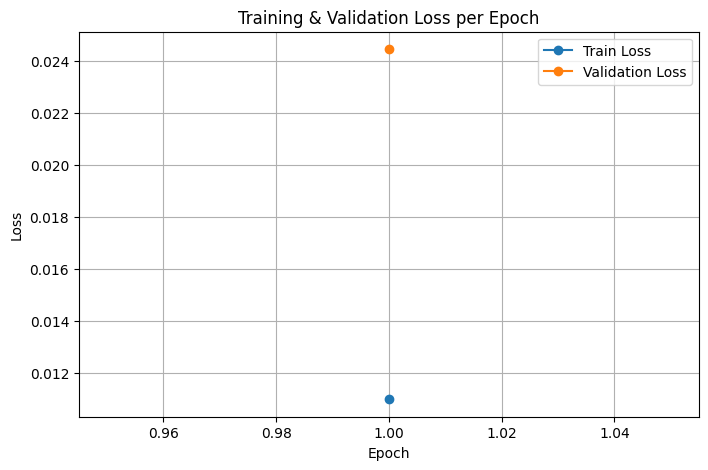


=== Epoch Loss Summary ===
 Epoch  Train Loss  Validation Loss
     1       0.011           0.0245

📁 Saved training log: qwen3_vl_32b_lora_pjw/training_log.csv


In [16]:
# ============================================
# 🚀 Full Training Loop with Validation & Graph + CSV Log
# ============================================

from tqdm.auto import tqdm
import math, torch
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
import pandas as pd
import os

# ---- 하이퍼파라미터 ----
EPOCHS = 1
PATIENCE = 2        # 개선이 2에폭 연속 없으면 조기 종료
GRAD_ACCUM = 6
LR = 6e-5

# ---- 경로 설정 ----
# ⭐ 경로 재설정 필요 (현재는 내 구글드라이브 상태로 연결한거라서, 다시 바꿔줘야함)
SAVE_DIR = "qwen3_vl_32b_lora_pjw"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---- 환경 세팅 ----
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
model = model.to(model.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

num_update_steps_per_epoch = math.ceil(len(train_loader) / GRAD_ACCUM)
num_training_steps = EPOCHS * num_update_steps_per_epoch
num_warmup_steps = max(1, int(num_training_steps * 0.05))

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
scaler = torch.cuda.amp.GradScaler(enabled=True)

# ---- 학습 상태 변수 ----
global_step = 0
train_losses, valid_losses = [], []
best_val = float("inf")
no_improve = 0

# ====================================
# 🔁 학습 루프
# ====================================
for epoch in range(EPOCHS):
    model.train()
    running, total_train_loss = 0.0, 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [train]", unit="batch")
    optimizer.zero_grad(set_to_none=True)

    # ----- TRAIN -----
    for step, batch in enumerate(progress_bar, start=1):
        batch = {k: (v.to(model.device) if hasattr(v, "to") else v) for k, v in batch.items()}

        with torch.cuda.amp.autocast(dtype=amp_dtype):
            outputs = model(**batch)
            loss = outputs.loss / GRAD_ACCUM

        scaler.scale(loss).backward()
        running += loss.item()
        total_train_loss += loss.item()

        if step % GRAD_ACCUM == 0:
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            global_step += 1

            avg_loss = running / GRAD_ACCUM
            progress_bar.set_postfix({"train_loss": f"{avg_loss:.3f}"})
            running = 0.0

    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # ----- VALIDATION -----
    model.eval()
    val_loss, val_steps = 0.0, 0
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=amp_dtype):
        for vb in tqdm(valid_loader, desc=f"Epoch {epoch+1} [valid]", unit="batch"):
            vb = {k: (v.to(model.device) if hasattr(v, "to") else v) for k, v in vb.items()}
            val_loss += model(**vb).loss.item()
            val_steps += 1
    val_avg = val_loss / max(1, val_steps)
    valid_losses.append(val_avg)
    print(f"[Epoch {epoch+1}] train loss {epoch_train_loss:.4f} | valid loss {val_avg:.4f}")

    # ----- BEST MODEL SAVE + EARLY STOPPING -----
    if val_avg < best_val:
        best_val = val_avg
        no_improve = 0
        model.save_pretrained(f"{SAVE_DIR}_best")
        processor.save_pretrained(f"{SAVE_DIR}_best")   # ← 이 줄 추가
        print(f"✅ Saved new best model (val_loss={val_avg:.4f})")
    else:
        no_improve += 1
        print(f"no improvement: {no_improve}/{PATIENCE}")
        if no_improve >= PATIENCE:
            print("⏹️ Early stopping.")
            break

    model.train()

# ====================================
# 🧩 학습 종료 후 마지막 모델 저장
# ====================================
model.save_pretrained(f"{SAVE_DIR}_last")
processor.save_pretrained(f"{SAVE_DIR}_last")
print(f"Saved final model at: {SAVE_DIR}_last")

# ====================================
# 📊 시각화 및 표 출력
# ====================================
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, len(valid_losses)+1), valid_losses, marker='o', label="Validation Loss")
plt.title("Training & Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ====================================
# 🗂️ CSV 로그 저장
# ====================================
epoch_data = pd.DataFrame({
    "Epoch": list(range(1, len(valid_losses)+1)),
    "Train Loss": [round(x, 4) for x in train_losses],
    "Validation Loss": [round(x, 4) for x in valid_losses]
})
epoch_data.to_csv(os.path.join(SAVE_DIR, "training_log.csv"), index=False)
print("\n=== Epoch Loss Summary ===")
print(epoch_data.to_string(index=False))
print(f"\n📁 Saved training log: {os.path.join(SAVE_DIR, 'training_log.csv')}")


In [ ]:

# 모델 저장
# SAVE_DIR = "qwen3_vl_32b_lora_commentLee"
# # LoRA 사용 중이면: 어댑터만 저장
# model.save_pretrained(SAVE_DIR)
# processor.save_pretrained(SAVE_DIR)
# print("Saved:", SAVE_DIR)


# inference

30분~1시간 소요

#### 실습 참고 내용

    챕터4-1 RAG 기반 Customer Service AI 에이전트 개발
    - 데이터 파서 : langchain_core.output_parsers(), StrOutputParser()

    챕터 3-1 Transfer Learning 기반의 CNN 모델 학습
    - 학습 루프 : 문제 6: 모델 학습을 위한 반복문
    - 추론 : with torch.no_grad(), model.eval()

In [ ]:
# ============================================
# ✅ 기존 추론 코드 유지 + LoRA 기반 BEST 모델 로드
# ============================================
import os, re, torch
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
from transformers import AutoProcessor, Qwen3VLForConditionalGeneration
from peft import PeftModel

# --- 경로 설정 ---
SAVE_DIR = "qwen3_vl_32b_lora_pjw"
MODEL_DIR = f"{SAVE_DIR}_best"  # LoRA 어댑터 폴더
os.makedirs(SAVE_DIR, exist_ok=True)

# --- 1️⃣ 베이스 모델 로드 ---
base_model = Qwen3VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen3-VL-32B-Instruct",   # 베이스 모델 (Hugging Face)
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)

# --- 2️⃣ LoRA 어댑터 덮어씌우기 ---
model = PeftModel.from_pretrained(
    base_model,
    MODEL_DIR,                      # LoRA fine-tuned checkpoint
    torch_dtype=torch.bfloat16,
    offload_dir="./offload", 
)
model.eval()

# --- 3️⃣ Processor 로드 ---
processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-32B-Instruct")

# pad_token 설정 (경고 방지용)
if processor.tokenizer.pad_token_id is None:
    processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id

# --------------------------------------------
# 데이터 로드 및 추론 루프
# --------------------------------------------
train_df = pd.read_csv("/home/team067/train.csv")
test_df  = pd.read_csv("/home/team067/test.csv")

def extract_choice(text: str) -> str:
    if not text:
        return "a"
    text = text.strip().lower()
    m = re.search(r'\b([abcd])\b', text)
    if m: return m.group(1)
    m = re.search(r'[\(\[\{<\s\-:]*([abcd])[\)\]\}>:.,\s]*$', text)
    if m: return m.group(1)
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    if lines:
        last = lines[-1]
        m = re.search(r'\b([abcd])\b', last)
        if m: return m.group(1)
        for tok in last.split():
            if tok in ("a","b","c","d"):
                return tok
    return "a"

preds = []
device = model.device

for i in tqdm(range(len(test_df)), desc="Inference", unit="sample"):
    row = test_df.iloc[i]
    img = Image.open(row["path"]).convert("RGB")
    user_text = build_mc_prompt(row["question"], row["a"], row["b"], row["c"], row["d"])

    messages = [
        {"role":"system","content":[{"type":"text","text":SYSTEM_INSTRUCT}]},
        {"role":"user","content":[
            {"type":"image","image":img},
            {"type":"text","text":user_text}
        ]},
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[img], return_tensors="pt").to(device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=2,
            do_sample=False,
            eos_token_id=processor.tokenizer.eos_token_id,
        )

    gen_part = out_ids[:, inputs["input_ids"].shape[1]:]
    output_text = processor.batch_decode(gen_part, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    choice = extract_choice(output_text)
    preds.append(choice)

# --- 제출 파일 생성 ---
submission = pd.DataFrame({"id": test_df["id"], "answer": preds})
sub_path = os.path.join(SAVE_DIR, "submission.csv")
submission.to_csv(sub_path, index=False)
print(f"✅ Saved submission.csv -> {sub_path}")

print("\n--- 선택지별 응답 횟수 ---")
print(submission["answer"].value_counts().sort_index())
# ============================================


Loading checkpoint shards: 100%|██████████| 14/14 [00:42<00:00,  3.06s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


ValueError: We need an `offload_dir` to dispatch this model according to this `device_map`, the following submodules need to be offloaded: base_model.model.model.language_model.layers.37, base_model.model.model.language_model.layers.38, base_model.model.model.language_model.layers.39, base_model.model.model.language_model.layers.40, base_model.model.model.language_model.layers.41, base_model.model.model.language_model.layers.42, base_model.model.model.language_model.layers.43, base_model.model.model.language_model.layers.44, base_model.model.model.language_model.layers.45, base_model.model.model.language_model.layers.46, base_model.model.model.language_model.layers.47, base_model.model.model.language_model.layers.48, base_model.model.model.language_model.layers.49, base_model.model.model.language_model.layers.50, base_model.model.model.language_model.layers.51, base_model.model.model.language_model.layers.52, base_model.model.model.language_model.layers.53, base_model.model.model.language_model.layers.54, base_model.model.model.language_model.layers.55, base_model.model.model.language_model.layers.56, base_model.model.model.language_model.layers.57, base_model.model.model.language_model.layers.58, base_model.model.model.language_model.layers.59, base_model.model.model.language_model.layers.60, base_model.model.model.language_model.layers.61, base_model.model.model.language_model.layers.62, base_model.model.model.language_model.layers.63, base_model.model.model.language_model.norm, base_model.model.model.language_model.rotary_emb, base_model.model.lm_head.

In [9]:
# ============================================
# ✅ 기존 추론 코드를 최대한 유지 + (BEST 모델 로드, 저장 경로만 수정)
# ============================================
import os, re, torch
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
from transformers import AutoProcessor, Qwen3VLForConditionalGeneration, BitsAndBytesConfig

# --- 저장 경로 설정 (학습 때 쓰던 SAVE_DIR과 동일하게) ---
# ⭐ 경로 재설정 필요 (현재는 내 구글드라이브 상태로 연결한거라서, 다시 바꿔줘야함)
SAVE_DIR = "qwen3_vl_32b_lora_pjw"
MODEL_DIR = f"{SAVE_DIR}_best"  # 베스트 체크포인트 사용
os.makedirs(SAVE_DIR, exist_ok=True)

# --- BEST 체크포인트 로드 ---
if not os.path.isdir(MODEL_DIR):
    raise FileNotFoundError(f"BEST 체크포인트 폴더가 없습니다: {MODEL_DIR}\n"
                            f"학습 시 {MODEL_DIR}가 저장되었는지 확인하세요.")
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True  # ← 핵심 옵션
)

model = Qwen3VLForConditionalGeneration.from_pretrained(
    MODEL_DIR,
    device_map="auto",       # GPU와 CPU 자동 분산
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    trust_remote_code=True
)



processor = AutoProcessor.from_pretrained(MODEL_DIR)

# pad_token 안전 설정 (경고 방지용)
if processor.tokenizer.pad_token_id is None:
    processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id

# --------------------------------------------
# (아래부터는 네가 쓰던 코드 그대로 유지)
# 데이터 파서 : 모델의 응답에서 선지를 추출
# --------------------------------------------
import re

def extract_choice(text: str) -> str:
    if not text:
        return "a"
    text = text.strip().lower()

    # 가장 먼저 정확히 a/b/c/d 단독 토큰 매칭
    m = re.search(r'\b([abcd])\b', text)
    if m:
        return m.group(1)

    # 괄호/콜론/닫힘기호가 붙은 형태까지 허용: (a), a), a:, - a
    m = re.search(r'[\(\[\{<\s\-:]*([abcd])[\)\]\}>:.,\s]*$', text)
    if m:
        return m.group(1)

    # 마지막 라인/토큰에서 다시 한 번 안전 검색
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    if lines:
        last = lines[-1]
        m = re.search(r'\b([abcd])\b', last)
        if m:
            return m.group(1)
        for tok in last.split():
            if tok in ("a","b","c","d"):
                return tok

    return "a"  # 최후의 안전장치

# 추론을 위해 모든 레이어 활성화
model.eval()
preds = []
train_df = pd.read_csv("/home/team067/train.csv")
test_df  = pd.read_csv("/home/team067/test.csv")

# (선택) pad_token 설정: 경고 방지용 — 기존 동작엔 영향 없음
if processor.tokenizer.pad_token_id is None:
    processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id

for i in tqdm(range(len(test_df)), desc="Inference", unit="sample"):
    row = test_df.iloc[i]
    img = Image.open(row["path"]).convert("RGB")
    user_text = build_mc_prompt(row["question"], row["a"], row["b"], row["c"], row["d"])

    messages = [
        {"role":"system","content":[{"type":"text","text":SYSTEM_INSTRUCT}]},
        {"role":"user","content":[
            {"type":"image","image":img},
            {"type":"text","text":user_text}
        ]},
    ]

    # 템플릿 적용(토크나이즈는 generate에서)
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[img], return_tensors="pt").to(device)

    with torch.no_grad():
      out_ids = model.generate(
          **inputs,
          max_new_tokens=2,          # 원래 값 유지(원하시면 1로 줄여도 됨)
          do_sample=False,
          eos_token_id=processor.tokenizer.eos_token_id,
      )

    # 🔧 입력 길이 이후(신규 토큰)만 슬라이스
    gen_part = out_ids[:, inputs["input_ids"].shape[1]:]
    output_text = processor.batch_decode(
        gen_part, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]

    choice = extract_choice(output_text)
    # 처음 테스트할때는 주석해제해서 응답제대로나오는지 확인
    # print(f"[{i}] output_text:", repr(output_text))
    # print(f"[{i}] extract_choice:", choice)
    preds.append(choice)


# 제출 파일 생성 (👉 SAVE_DIR 밑으로 저장)
submission = pd.DataFrame({"id": test_df["id"], "answer": preds})
sub_path = os.path.join(SAVE_DIR, "submission.csv")
submission.to_csv(sub_path, index=False)
print(f"Saved submission.csv -> {sub_path}")

# ===== abcd 선택 횟수 출력 =====
print("\n--- 선택지별 응답 횟수 ---")
# .sort_index()를 사용하면 a, b, c, d 순서로 정렬되어 나옵니다.
print(submission["answer"].value_counts().sort_index())
# ========================================================


Loading checkpoint shards: 100%|██████████| 14/14 [02:47<00:00, 11.96s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
/home/team067/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:2441: UserWarning: for model.language_model.layers.6.self_attn.q_proj.lora_A.default.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/team067/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:2441: UserWarning: for model.language_model.layers.6.self_attn.q_proj.lora_B.default.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the mod

ValueError: weight is on the meta device, we need a `value` to put in on cpu.

In [25]:
# 모델 응답 예시
print(output_text)

c


## 검증셋에 대한 혼동행렬

Validation Analysis: 0it [00:00, ?it/s]

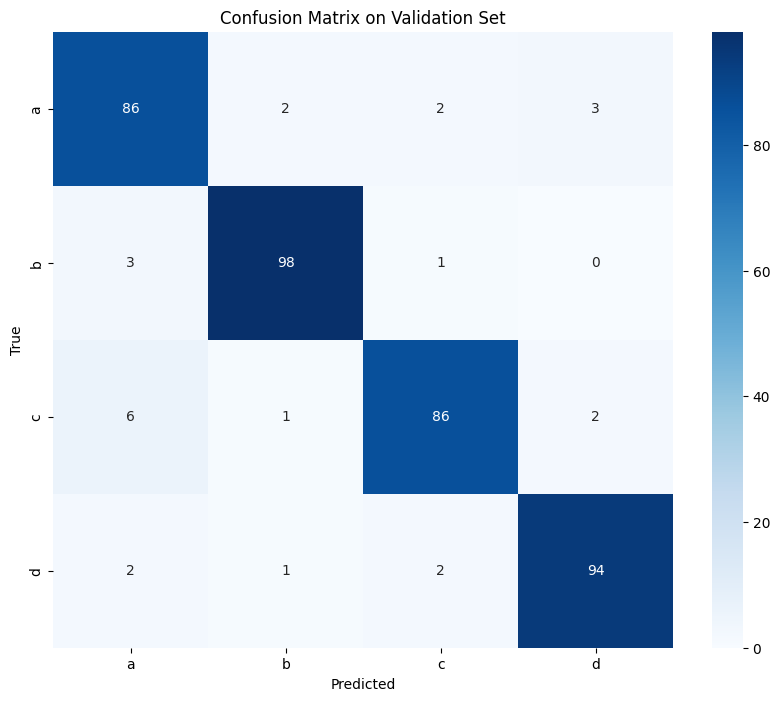


Classification Report:
              precision    recall  f1-score   support

           a       0.89      0.92      0.91        93
           b       0.96      0.96      0.96       102
           c       0.95      0.91      0.92        95
           d       0.95      0.95      0.95        99

    accuracy                           0.94       389
   macro avg       0.94      0.94      0.94       389
weighted avg       0.94      0.94      0.94       389


=== Error Pattern Analysis ===

Q: 이 한식 세트 메뉴에 포함되지 않은 음식은 무엇인가요?
True: c, Predicted: a

Q: 이 음식 세트에 포함되지 않은 것은 무엇인가요?
True: c, Predicted: a

Q: 이 골목길에서 볼 수 없는 것은 무엇인가요?
True: a, Predicted: c

Q: 이 음식 세트 중에서 국물 요리는 무엇인가요?
True: a, Predicted: b

Q: 이 사진에서 기린에게 먹이를 주기 위해 사용된 도구는 무엇인가요?
True: c, Predicted: d


In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_predictions(valid_subset, model, processor, device="cuda"):
    true_labels = []
    pred_labels = []

    model.eval()
    for i, row in tqdm(valid_subset.iterrows(), desc="Validation Analysis"):
        # 실제 라벨 저장
        true_labels.append(row["answer"])

        # 예측 수행
        img = Image.open(row["path"]).convert("RGB")
        user_text = build_mc_prompt(row["question"], row["a"], row["b"], row["c"], row["d"])

        messages = [
            {"role":"system", "content":[{"type":"text", "text":SYSTEM_INSTRUCT}]},
            {"role":"user", "content":[
                {"type":"image", "image":img},
                {"type":"text", "text":user_text}
            ]},
        ]

        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(text=[text], images=[img], return_tensors="pt").to(device)

        with torch.no_grad():
            out_ids = model.generate(**inputs, max_new_tokens=2)
            gen_part = out_ids[:, inputs["input_ids"].shape[1]:]
            output_text = processor.batch_decode(gen_part, skip_special_tokens=True)[0]
            pred = extract_choice(output_text)
            pred_labels.append(pred)

    # 혼동 행렬 생성
    cm = confusion_matrix(true_labels, pred_labels, labels=['a', 'b', 'c', 'd'])

    # 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['a', 'b', 'c', 'd'],
                yticklabels=['a', 'b', 'c', 'd'])
    plt.title('Confusion Matrix on Validation Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 상세 메트릭 출력
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels))

    # 오답 분석
    error_cases = []
    for i, (true, pred) in enumerate(zip(true_labels, pred_labels)):
        if true != pred:
            error_cases.append({
                'idx': valid_subset.index[i],
                'question': valid_subset.iloc[i]['question'],
                'true': true,
                'pred': pred
            })

    return error_cases

# 실행
error_cases = analyze_predictions(valid_subset, model, processor)

# 오답 패턴 분석
print("\n=== Error Pattern Analysis ===")
for case in error_cases[:5]:  # 첫 5개 오답 케이스만 출력
    print(f"\nQ: {case['question']}")
    print(f"True: {case['true']}, Predicted: {case['pred']}")